# Домашнее задание № 2. Мешок слов

## Задание 1 (3 балла)

У векторайзеров в sklearn есть встроенная токенизация на регулярных выражениях. Найдите способо заменить её на кастомную токенизацию

Обучите векторайзер с дефолтной токенизацией и с токенизацией razdel.tokenize. Обучите классификатор с каждым из векторизаторов. Сравните метрики и выберете победителя. 

(в вашей тетрадке должен быть код обучения и все метрики; если вы сдаете в .py файлах то сохраните полученные метрики в отдельном файле или в комментариях)

Ссылка на датасет: https://www.kaggle.com/blackmoon/russian-language-toxic-comments

In [51]:
import pandas as pd
import numpy as np
import math

import re

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from razdel import tokenize

In [20]:
data = pd.read_csv('labeled.csv')

In [21]:
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


Распределение классов:

<AxesSubplot:>

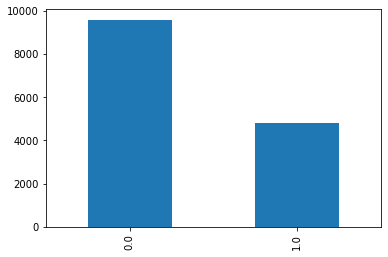

In [22]:
data['toxic'].value_counts().plot(kind="bar")

### Векторизация

In [23]:
# делим датасет на обучающую и тестовую выборки в отношении 90/10
train, test = train_test_split(data, test_size=0.1, shuffle=True)

Y_train = train.toxic.values
Y_test = test.toxic.values

In [24]:
# векторизация с дефолтной токенизацией
default_vectorizer = CountVectorizer()
X_default_tokens = default_vectorizer.fit_transform(train.comment)
X_test_1 = default_vectorizer.transform(test.comment) 

In [25]:
# токенизация текста с razdel
def tokenize_via_razdel(text):
    tokens = list(tokenize(text))
    tokens = [_.text for _ in tokens]
    return(tokens)

# векторизация с токенизацией из razdel
custom_vectorizer = CountVectorizer(tokenizer=tokenize_via_razdel)
X_razdel_tokens = custom_vectorizer.fit_transform(train.comment)
X_test_2 = custom_vectorizer.transform(test.comment) 

Посмотрим на размерности получившихся матриц:

In [26]:
X_default_tokens.shape

(12970, 63674)

In [27]:
X_razdel_tokens.shape

(12970, 64616)

### Fit/Predict via LogReg 

In [28]:
# обучаем классификатор с дефолтным векторайзером
clf_1 = LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)
clf_1.fit(X_default_tokens, Y_train)

# обучаем классификатор с кастомным векторайзером
clf_2 = LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)
clf_2.fit(X_razdel_tokens, Y_train)

# получаем предсказания классификаторов для тестовых примеров
predictions_1 = clf_1.predict(X_test_1)
predictions_2 = clf_2.predict(X_test_2)

### Сравнение метрик, выбор лучшей модели

В таблице представлены метрики для двух классификаторов: accuracy и *взвешенное среднее* для precision, recall, f1. Если округлять до сотых, то различий в качестве не будет. Но если оставить 4 знака, то видно, что классификатор с токенизацией на основе razdel немного лучше, чем модель с дефолтной токенизацией. 

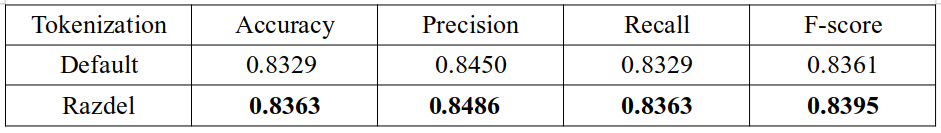

*Note: при повторном запуске кода значения метрик поменяются, так как документы в датасете перемешиваются*

**Вывод:** векторизация с razdel-токенизацией позволяет немного повысить качество классификатора. Однако улучшение очень незначительное: разница между f-мерами двух классификаторов составила 0.0034.

In [29]:
# метрики для классификатора с дефолтным векторайзером
print(classification_report(Y_test, predictions_1, digits=4))

              precision    recall  f1-score   support

         0.0     0.9122    0.8352    0.8720       983
         1.0     0.7011    0.8279    0.7592       459

    accuracy                         0.8329      1442
   macro avg     0.8067    0.8315    0.8156      1442
weighted avg     0.8450    0.8329    0.8361      1442



In [30]:
# метрики для классификатора с кастомным векторайзером
print(classification_report(Y_test, predictions_2, digits=4))

              precision    recall  f1-score   support

         0.0     0.9155    0.8372    0.8746       983
         1.0     0.7053    0.8344    0.7645       459

    accuracy                         0.8363      1442
   macro avg     0.8104    0.8358    0.8195      1442
weighted avg     0.8486    0.8363    0.8395      1442



## Задание 2 (3 балла)

Преобразуйте таблицу с абсолютными частотностями в семинарской тетрадке в таблицу с tfidf значениями. (Таблица - https://i.ibb.co/r5Nc2HC/abs-bow.jpg) Формула tfidf есть в семинаре на картинке с пояснениями на английском. 
Считать нужно в питоне. Формат итоговой таблицы может быть любым, главное, чтобы был код и можно было воспроизвести вычисления. 

Преобразованная таблица:

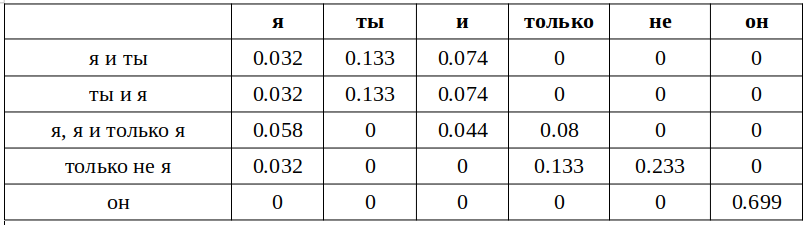

In [31]:
# исходные данные
data = ['я и ты', 'ты и я', 'я я и только я', 'только не я', 'он']
# токенизируем каждое предложение
data = [tokenize_via_razdel(d) for d in data]
# задаем словарь
vocabulary = ['я', 'ты', 'и', 'только', 'не', 'он']

def calculate_tf_idf(docs_tokenized, vocab):
    N = len(docs_tokenized)
    V = len(vocab)
    result = np.zeros((N, V))    
    for i in range(0, N):
        doc = docs_tokenized[i]
        for w in doc:
            j = vocab.index(w)
            # считаем tf
            tf = doc.count(w)/len(doc)
            df = 0
            # считаем df
            for d in docs_tokenized:
                if w in d:
                    df += 1
            idf = np.log10(N/df)
            tfidf = tf * idf
            result[i, j] = round(tfidf, 3)
            
    return result
                
print(calculate_tf_idf(data, vocabulary))  

[[0.032 0.133 0.074 0.    0.    0.   ]
 [0.032 0.133 0.074 0.    0.    0.   ]
 [0.058 0.    0.044 0.08  0.    0.   ]
 [0.032 0.    0.    0.133 0.233 0.   ]
 [0.    0.    0.    0.    0.    0.699]]


## Задание 3 (2 балла) 

Обучите 2 любых разных классификатора из семинара. Предскажите токсичность для текстов из тестовой выборки (используйте одну и ту же выборку для обоих классификаторов) и найдите 10 самых токсичных для каждого из классификаторов. Сравните получаемые тексты - какие тексты совпадают, какие отличаются, правда ли тексты токсичные?

Требования к классификаторам:   
а) один должен использовать CountVectorizer, другой TfidfVectorizer  
б) у векторазера должны быть вручную заданы как минимум 5 параметров  
в) у классификатора должно быть задано вручную как минимум 2 параметра  
г)  f1 мера каждого из классификаторов должна быть минимум 0.75  

### Model 1. CountVectorizer + Naive Bayes

Загрузка списка стоп-слов для русского языка из библиотеки NLTK

In [32]:
nltk.download("stopwords") # загрузка списка стоп-слов
russian_stopwords = stopwords.words("russian") 

[nltk_data] Downloading package stopwords to /home/lisa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
count_vectorizer = CountVectorizer(tokenizer=tokenize_via_razdel, stop_words=russian_stopwords,
                            max_features=1000, min_df=5, max_df=0.4)
X = count_vectorizer.fit_transform(train.comment)
X_test = count_vectorizer.transform(test.comment)

In [47]:
nb_classifier = MultinomialNB(alpha=1., fit_prior=True)
nb_classifier.fit(X, Y_train)

preds = nb_classifier.predict(X_test)

In [48]:
print(classification_report(Y_test, preds, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84       983
         1.0       0.68      0.52      0.59       459

    accuracy                           0.77      1442
   macro avg       0.74      0.70      0.71      1442
weighted avg       0.76      0.77      0.76      1442



In [126]:
probs = nb_classifier.predict_proba(X_test)
# оставляем только вероятности для токсичного класса (1)
toxic_probs = [p[1] for p in probs]

comments = test.comment.tolist()

res = dict(zip(comments, toxic_probs))
res_sorted = {f'{k} : {v}': v for k, v in sorted(res.items(), key=lambda item: item[1])}

top_ten_nb = list(res_sorted)[-10:]

⚠️ 🤬 TOP 10 toxic comments for NB classifier:

In [123]:
top_ten_nb

['Поясните че с ним случилось на ласт стриме хохлы\n|0.9727785691517121',
 'Якуты сила. Моё увожение. Удел пидорахи - уважать расистов-погромщиков. Русские холопы только перед силой преклоняются\n|0.9729665215500491',
 'Эдвард Билл вас в жопу бил? Ыыыыы мазафакка сука\n|0.9742928512640455',
 'Целью встречи стали переговоры о сохранении поставок газа А что, у него есть полномочия вести такие переговоры? Сука блядский цирк. Какие же хохлы дегенераты, пиздец просто\n|0.9752348488283342',
 'а всех русофобствующих по рашников, хохлов, окатышей - забанить и пидорнуть в ньюсач Пидорашка не палится.\n|0.9771493874756672',
 'Чому она хохлов так ненавидит?\n|0.9831368705111911',
 'Пидорашек выселить, а не хохлов Ты сам себе противоречишь, дурачок.\n|0.9852037272346809',
 'НУ ЧО СУКА ПРОСИЛ СКЕТЧИ? ПРОСИЛ? ПОЛУЧАЙ БЛЯДЬ!!\n|0.9888639011784247',
 'ряяяге У, сука ссыкливая, скажи мне это в лицо.\n|0.9898306875397478',
 'Блять какой же жырный сука старый! Сороковник ему небось...\n|0.990840219348199

### Model 2. TF-IDF + LogReg

In [65]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_via_razdel, stop_words=russian_stopwords,
                            max_features=1000, min_df=4, max_df=0.4)

X = tfidf_vectorizer.fit_transform(train.comment)
X_test = tfidf_vectorizer.transform(test.comment)

In [66]:
logreg_classifier = LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)
logreg_classifier.fit(X, Y_train)

preds = logreg_classifier.predict(X_test)

In [67]:
print(classification_report(Y_test, preds, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.86      0.77      0.82       983
         1.0       0.60      0.73      0.66       459

    accuracy                           0.76      1442
   macro avg       0.73      0.75      0.74      1442
weighted avg       0.78      0.76      0.77      1442



In [127]:
probs = logreg_classifier.predict_proba(X_test)
# оставляем только вероятности для токсичного класса (1)
toxic_probs = [p[1] for p in probs]

comments = test.comment.tolist()

res = dict(zip(comments, toxic_probs))
res_sorted = {f'{k} :  {v}': v for k, v in sorted(res.items(), key=lambda item: item[1])}

top_ten_logreg = list(res_sorted)[-10:]

⚠️ 🤬 TOP 10 toxic comments for LogReg classifier:

In [128]:
top_ten_logreg

['КАКИЕ ХОХЛЫ?! два урода. при чём ту вообще ХОХЛЫ! аноны, смотрите! я двух шлюх проплаченых поймал!\n :  0.8523192700784018',
 'Какие же хохлы незалежные дегенераты, пиздец просто.\n :  0.853956960214416',
 'куколдыш Иди значение выучи, мурло Скоро и тебе пиздарики наступят. Что сделаешь, насрешь под дверью, ЧМО?\n :  0.8581592282990994',
 'Тебе не похуй, пидорас ебучий?\n :  0.8670507307902792',
 'Чому она хохлов так ненавидит?\n :  0.8680429952106874',
 'Свин, иди нахуй. Можно хоть один тред без политоты? Даже тебя хуеосить не хочется, давай лучше про няшек-фигуристок говорить.\n :  0.8696793433707911',
 'Блять какой же жырный сука старый! Сороковник ему небось...\n :  0.8706349634919428',
 'Иди нахуй,бля. Я искал эту хуйню так как дрочу в гостиницах, когда в командировки летаю. Сплю бухой без трусов. Мне нужная эта ебень.\n :  0.8876528208385862',
 'Хохол, тебе разве Петя разрешил в эфир выходить? Иди Томос встречай.\n :  0.8899308281894605',
 'Нахуй иди, я тебе весь тред что ли чи

### Анализ результатов ⚠️ 🤬

<br>
Среднее взвешенное F-меры для двух классификаторов:

| Classifier    | F-score |
| ----------- | ----------- |
| Naive Bayes      |    0.76    |
| Log Reg   | 0.77        |

**Сравнение токсичных комментариев** 
<br>
Для каждого классификатора ТОP-10 токсичных комментариев получился разным. Все комментарии в     ТОП-ах действительно токсичны, так как содержат мат и ругательства. 
<br>
Совпали только 2 комментария:
<br>
1)  Чому она хохлов так ненавидит?
<br>
2)  Б🤬ь какой же жырный с🤬а старый! Сороковник ему небось...
<br>

При этом комментарий 1 не настолько токсичен, как комментарии с матом. Тем не менее, обе модели определили данный комментарий как один из самых токсичных. 